In [71]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np

import os
import pandas as pd
from torchvision.io import read_image

# Create an example dataset

In [72]:
class MockData(object):
    """This object is a callable mock data generator"""
    def __init__(self, a=1, b=2, c=3, ):
        self.a = a
        self.b = b
        self.c = c
        
    def __call__(self, x):
        result = self.a + self.b * x + self.c * x ** 2
        return result
    

    

In [73]:
md = MockData()

In [98]:
xarr = np.random.normal(loc=-1, size=10000).astype(float)

In [99]:
yarr = md(xarr)

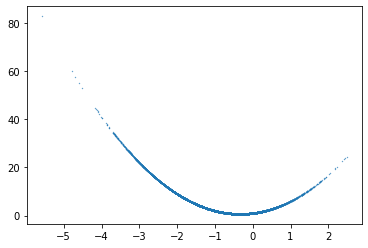

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(xarr, yarr, s=0.1)

In [77]:
xarr

array([-1.27860197, -1.26294072, -1.96554101, ..., -1.30214997,
        0.35874897, -0.30929849])

## Creating custom data loader

In [225]:
class CustomFunctionDataset(Dataset):
    def __init__(self, xarr, yarr, transform=None, target_transform=None):
        self.xarr = xarr
        self.yarr = yarr
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(xarr)

    def __getitem__(self, idx):
        xval = np.array([xarr[idx],])
        yval = np.array([yarr[idx],])
        if self.transform:
            xval = self.transform(xval)
        if self.target_transform:
            yval = self.target_transform(yval)
        return xval.astype(np.single), yval.astype(np.single)

In [226]:
cfd = CustomFunctionDataset(xarr, yarr)

In [227]:
cfd[1]

(array([-0.10323229], dtype=float32), array([0.82550615], dtype=float32))

# Prepare for training network

## Prepare test and training data

In [228]:
2**18

262144

In [239]:
data_size = 2 ** 18
batch_size = 32

xarr_train = np.random.normal(loc=-1, size=data_size).astype(np.single)
yarr_train = md(xarr_train).astype(np.single)

xarr_test = np.random.normal(loc=-1, size=data_size).astype(np.single)
yarr_test = md(xarr_test).astype(np.single)

# Create data loaders.
training_data = CustomFunctionDataset(xarr_train, yarr_train)
test_data = CustomFunctionDataset(xarr_test, yarr_test)


train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1])
Shape of y: torch.Size([64, 1]) torch.float32


### Define model

In [240]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# This should be using cuda device

Using cuda device


In [241]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=1, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1),
        )
        self.float()
        
    def forward(self, x):
        x = self.flatten(x).float()
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Defining optimizer and loss function 

In [242]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [243]:
def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch % 100 == 0) & verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [244]:
def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [245]:
epochs = 100
for t in range(epochs-1):
    if t % 10 == 0:        
        print(f"Epoch {t+1}\n-------------------------------")
        verbose = True
    else: 
        verbose = False
    train(train_dataloader, model, loss_fn, optimizer, verbose=verbose)
    test(test_dataloader, model, loss_fn, verbose=verbose)
    
train(train_dataloader, model, loss_fn, optimizer, verbose=True)
test(test_dataloader, model, loss_fn, verbose=True)    
print("Done!")

Epoch 1
-------------------------------
loss: 63.626575  [    0/10000]
loss: 6.743835  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 12.042826 

Epoch 11
-------------------------------
loss: 1.269513  [    0/10000]
loss: 2.547653  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.513248 

Epoch 21
-------------------------------
loss: 0.111375  [    0/10000]
loss: 0.177620  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.581204 

Epoch 31
-------------------------------
loss: 0.065024  [    0/10000]
loss: 0.117870  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.361898 

Epoch 41
-------------------------------
loss: 0.144208  [    0/10000]
loss: 0.058950  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.262361 

Epoch 51
-------------------------------
loss: 0.029147  [    0/10000]
loss: 0.282437  [ 6400/10000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.205931 

Epoch 61
-------------------------------
loss: 0.081720  [    0/10000]
loss: 0.043596  

In [246]:
with torch.no_grad():
    xvals = []
    pvals = []
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X).cpu().numpy()
        xvals.append(X.cpu().numpy())
        pvals.append(pred)

pvals = np.concatenate(pvals)
xvals = np.concatenate(xvals)
#pvals = torch.concat(pvals)
#xvals = torch.concat(xvals)

Text(0, 0.5, 'f ( x )')

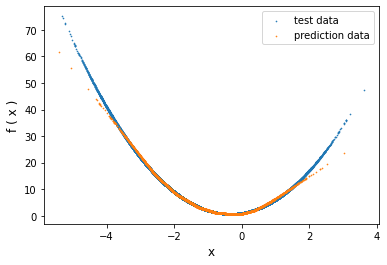

In [254]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(xarr_test, yarr_test, s=0.4, label="test data")
ax.scatter(xvals, pvals, s=0.4, label="prediction data")
ax.legend()
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f ( x )', fontsize=12)